<a href="https://colab.research.google.com/github/singhsa3/Emotions/blob/main/usingw2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

pathG='/content/drive/MyDrive/Pract/data' 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import librosa, librosa.display
import matplotlib.pyplot as plt

import os
import glob

import cv2
!pip3 install pickle5
import pickle5 as pickle
from PIL import Image as im

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/Pract/data/w2v2_pkl"

In [ ]:
# Get data list
"""
Created on Tue Jun  7 20:48:17 2022

@author: sanjeev
"""

import argparse
import math
import sys
import time
import copy
import numpy as np

import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization #, regularizers
from keras.layers.noise import GaussianNoise
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical


import os

#os.chdir('/media/sanjeev/Data/Pract/Practicum/codesNdata/mycode')
#pathG='../data'

import pandas as pd
df=pd.read_csv(pathG+"/labels/Yared Alemu_fear.csv")
df = df.reset_index()
df['name2'] =df['name'].apply (lambda x: x.split(".")[0]+".pickle")


import glob

import os
 
filenames= glob.glob(DATASET_PATH+"/*.pickle" )
filenames = [os.path.basename(x) for x in filenames]



In [ ]:
# This is to get maximum size of the array
fl= DATASET_PATH +"/"+df.iloc[0]['name2']
with open(fl,"rb") as f:
  x=pickle.load(f)
l = [x[0].shape[0]]
w = [x[0].shape[1]] #np.expand_dims(x, axis=0) 
#print(arr.shape)
for i,row in df.iterrows():
    if i>0:
        fl = DATASET_PATH+"/"+row['name2']
        with open(fl,"rb") as f:
          x=pickle.load(f) 
        l.append(x[0].shape[0])      
        w.append(x[0].shape[1])
        #print(l[-1], w[-1])
#labels=np.array(df.emotion)
l95=int(np.percentile(l,95))
x=None

In [ ]:
# This is to delete the rows greater than max size
df2=df.copy(deep=True)
for i,row in df.iterrows():    
    fl = DATASET_PATH+"/"+row['name2']
    with open(fl,"rb") as f:
      x=pickle.load(f)     
    l1 = x[0].shape[0]
    w1 = x[0].shape[1] 
    if l1> l95:
      try:
        #print(i)
        df2=df2.drop(df.iloc[i].name)
      except:
        print(i,l1)
        print("encountered and error")

df= df2.reset_index()
x=None

In [ ]:
df= df.reset_index()

In [ ]:
# Normalizing all the data to same size and create batches to reduce momory footprint
def datanumpy(batch_size, start, df):
  fl= DATASET_PATH +"/"+df.iloc[0]['name2']
  with open(fl,"rb") as f:
    x=pickle.load(f)
  l1 = x[0].shape[0]
  arr=np.pad(x.cpu().detach().numpy(), ((0,0), (10,l95-l1+1), (0, 0)), 'constant')

  j=start
  idx=[]
  for i,row in df.iterrows():
    if (i>=j and i<=batch_size+j-1):      
      fl = DATASET_PATH+"/"+row['name2']
      with open(fl,"rb") as f:
        x=pickle.load(f)
      l1 = x[0].shape[0]
      try:
        arr2=np.pad(x.cpu().detach().numpy(), ((0,0), (10,l95-l1+1), (0, 0)), 'constant')
        arr = np.vstack((arr,arr2))
        idx.append(i)
        #print(i)
        x=None
      except:
        print(l1)    
  
  arr =np.delete(arr, (0), axis=0) # First row was dummy row
  l=arr.shape[1]
  w= arr.shape[2]
  end = batch_size+j-1
  arr = arr.reshape(arr.shape[0],l,w,1)
  labels=np.array(df.emotion.iloc[idx])
  return start, end , arr , labels 

In [ ]:
fl= DATASET_PATH +"/"+df.iloc[0]['name2']
with open(fl,"rb") as f:
  x=pickle.load(f)

In [ ]:
c= x[0].numpy().T
b = np.max(c)
a = np.min(c)
c =255*(c-a)/(b-a)
c=c.astype(np.uint8)
data=im.fromarray(c)
data = data.resize((224,224) )
c=np.array(data)


(224, 224)

In [ ]:
arr=np.pad(x.cpu().detach().numpy(), ((0,0), (10,l95+l1+1), (0, 0)), 'constant')

In [ ]:
arr.shape

(1, 14591, 768)

In [ ]:
# Normalizing all the data to same size and create batches to reduce momory footprint
def imgconvert(df):
  fl= DATASET_PATH +"/"+df.iloc[0]['name2']
  with open(fl,"rb") as f:
    x=pickle.load(f)
  l1 = x[0].shape[0]
  x=np.pad(x.cpu().detach().numpy(), ((0,0), (10,l95-l1+1), (0, 0)), 'constant')
  c= x[0].T
  b = np.max(c)
  a = np.min(c)
  c =255*(c-a)/(b-a)
  c=c.astype(np.uint8)
  data=im.fromarray(c)
  data = data.resize((224,224) )
  arr=np.array(data)
  arr = arr.reshape(1,224,224)
  #print(arr.shape)
  j=start
  idx=[]
  for i,row in df.iterrows():      
    fl = DATASET_PATH+"/"+row['name2']
    with open(fl,"rb") as f:
      x=pickle.load(f)
    l1 = x[0].shape[0]
    try:
      x=np.pad(x.cpu().detach().numpy(), ((0,0), (10,l95-l1+1), (0, 0)), 'constant')
      c= x[0].T
      b = np.max(c)
      a = np.min(c)
      c =255*(c-a)/(b-a)
      c=c.astype(np.uint8)
      data=im.fromarray(c)
      data = data.resize((224,224) )
      arr2=np.array(data)
      arr2 = arr2.reshape(1,224,224)
      #print(arr2.shape)
      arr = np.vstack((arr,arr2))
      idx.append(i)
      #print(i)
      x=None
    except:
      print(l1)   
  
  arr =np.delete(arr, (0), axis=0) # First row was dummy row
  #l=arr.shape[1]
  #w= arr.shape[2]
  #arr = arr.reshape(1,224,224)
  labels=np.array(df.emotion.iloc[idx])
  return arr , labels 

In [ ]:
arr, labels =imgconvert(df)

In [ ]:
arr.shape

(416, 224, 224)

In [ ]:
#https://datascience.stackexchange.com/questions/26833/is-there-away-to-change-the-metric-used-by-the-early-stopping-callback-in-keras
#https://stackoverflow.com/questions/37657260/how-to-implement-custom-metric-in-keras
class EarlyStopByF1(keras.callbacks.Callback):
    from sklearn.metrics import f1_score
    def __init__(self, verbose = 0, n=10):
        super(keras.callbacks.Callback, self).__init__()        
        self.verbose = verbose
        self.lst = [100000]*n
        self.finalscore = 0

    def on_epoch_end(self, epoch, logs={}):
         predict = np.asarray(self.model.predict(self.validation_data[0]))
         target = self.validation_data[1]
         score = f1_score(target, prediction)
         selffinalscore =score
         self.lst.insert(0, score)
         self.lst.pop()
         if score > np.mean(self.lst):
            if self.verbose >0:
                print("Epoch %05d: early stopping Threshold" % epoch)
            self.model.stop_training = True
    def get_data(self):
        return selffinalscore

In [ ]:
def create_model( img_rows, img_cols, filters):
  #size of parameters 
  num_classes = 2  
  noise = 1
  droprate=0.25

  input_shape = ( img_rows, img_cols,filters)
  #Start Neural Network
  model = Sequential()
  #convolution 1st layer
  model.add(Conv2D(8, kernel_size=(3, 3), 
                  activation='relu', padding="same",
                  input_shape=input_shape)) 
  model.add(AveragePooling2D(pool_size=(2, 2)))


  #convolution 2nd layer
  model.add(Conv2D(16, kernel_size=(3, 3),  padding="same",
                  activation='relu')) 
  model.add(AveragePooling2D(pool_size=(2, 2)))

  #convolution 3rd layer
  model.add(Conv2D(32, kernel_size=(3, 3),  padding="same",
                  activation='relu')) 
  model.add(AveragePooling2D(pool_size=(2, 2)))


  #Fully connected 1st layer
  model.add(Flatten())
  model.add(Dense(25088,use_bias=True)) 
  model.add(Activation('relu')) 
  #model.add(Dropout(droprate)) 

  model.add(Dense(2048,use_bias=True)) 
  model.add(Activation('relu'))   


  model.add(Dense(2048, use_bias=True)) 
  model.add(Activation('relu'))      

  #Fully connected final layer
  model.add(Dense(2)) 
  model.add(Activation('softmax')) 

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.rmsprop_v2.RMSProp(),
                metrics=[tf.keras.metrics.Recall()])
  return model

In [ ]:
# Creating a dataframe with 70%
# values of original dataframe
df_train= df.sample(frac = 0.9)
df_test = df.drop(df_train.index) 
# Reset index require for batch to work
df_train = df_train.reset_index()
df_test = df_test.reset_index()
#del df
# Create a universal test set
start, end , val_x ,val_y = datanumpy(df_test.shape[0], 0, df_test)
val_y = val_y.astype(int)
print(start, end, df_test.shape)

0 12 (13, 9)


In [ ]:
val_x[0].shape
from PIL import Image as im
data = im.fromarray(val_x[0].reshape(1729,768))


In [ ]:
c.shape

(1729, 768)

In [ ]:
np.expand_dims(c, axis=2).shape

(1729, 768, 1)

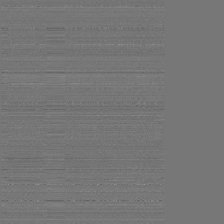

In [ ]:
data

In [ ]:
from sklearn.model_selection import train_test_split
batch_size=1
start =0
start, end , train_x , train_y = datanumpy(batch_size, start, df_train)
train_y = train_y.astype(int)

#reshape data
y_train_CNN = train_y
X_train_CNN = train_x
print('train shape after reshape: {}'.format(X_train_CNN.shape))

y_test_CNN = val_y
X_test_CNN = val_x
print('test shape after reshape: {}'.format(X_test_CNN.shape))

# one hot encode outputs
y_train_CNN = to_categorical(y_train_CNN)
y_test_CNN = to_categorical(y_test_CNN)
num_classes = y_train_CNN.shape[1]

train shape after reshape: (1, 1729, 768, 1)
test shape after reshape: (13, 1729, 768, 1)


In [ ]:
# define path to save model
model_path = './fm_cnn_BN.h5'
# prepare callbacks
callbacks = [
    EarlyStopping(
        monitor='val_acc', 
        patience=10,
        mode='max',
        verbose=1),
    ModelCheckpoint(model_path,
        monitor='val_acc', 
        save_best_only=True, 
        mode='max',
        verbose=0)
]


In [ ]:
epochs=50
img_rows=X_train_CNN.shape[1]
img_cols=X_train_CNN.shape[2]
print(img_rows, img_cols)
filters= 1
import tensorflow as tf
model=create_model(img_rows,img_cols,filters)

1729 768


ResourceExhaustedError: ignored

In [ ]:
epochs=50
img_rows=X_train_CNN.shape[1]
img_cols=X_train_CNN.shape[2]
filters= 1
import tensorflow as tf
model=create_model(img_rows,img_cols,filters)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.rmsprop_v2.RMSProp(),
              metrics=[tf.keras.metrics.Recall()])

model.summary()

#Save Model=ON
history = model.fit(X_train_CNN, y_train_CNN,
          batch_size= batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_CNN, y_test_CNN),shuffle=True,callbacks=callbacks)

score = model.evaluate(X_test_CNN, y_test_CNN, verbose=1)

#print loss and accuracy
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Create a basic model instance
epochs=50
img_rows=X_train_CNN.shape[1]
img_cols=X_train_CNN.shape[2]
filters= 1
model=create_model(img_rows,img_cols,1)
metrics = EarlyStopByF1(verbose=1)
model.fit(X_train_CNN, y_train_CNN, batch_size=batch_size, epochs = epochs, verbose=1, validation_data = (X_test_CNN, y_test_CNN),shuffle=True,callbacks=callbacks)
score = model.evaluate(X_test_CNN, y_test_CNN, verbose=1)

#print loss and accuracy
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# saving the model in tensorflow format
model.save('./wave2vec2',save_format='tf')

In [ ]:
# loading the saved model
loaded_model = tf.keras.models.load_model('./wave2vec2')
# retraining the model
loaded_model.fit(x_train, y_train, epochs = 10, validation_data = (x_test,y_test),verbose=1)

In [ ]:
 start, end , arr , labels  = datanumpy(10, 10)

In [ ]:
ab[2].shape

In [ ]:
ab[2].reshape(10,4628,768,1).shape